In [166]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from genderize import Genderize
from IPython.display import Image
import json
from urllib.request import urlopen
from urllib.parse import quote

%matplotlib inline

## Load data

In [151]:
outfile = "../data/img/init_coa_graph.png"
new_plot = False
g = igraph.load('../data/florida_coa_graph',format='pickle')
buy_names = True # if this is true, and you run the notebook, it will use all your gender api credits

#Here is how to map for to get authors / papers
method = 'florida'
a_2_node = np.load('%s/data/%s_a_2_node.npy'%('..',method),allow_pickle='TRUE').item()
a_2_paper = np.load('%s/data/%s_a_2_paper.npy'%('..',method),allow_pickle='TRUE').item()
node_2_a = np.load('%s/data/%s_node_2_a.npy'%('..',method),allow_pickle='TRUE').item()

# load gender api key (you'll need to make this txt file if you dont have one)
if buy_names:
    f = open("../data/genderAPI_key.txt", "r")
    genderAPI_key = f.readline().replace('\n', '')

In [138]:
g.summary()

'IGRAPH UN-- 151936 1492921 -- \n+ attr: name (v), year (e)'

In [157]:
# remove nodes with degree 0
g.vs.select(_degree=0).delete()

In [126]:
visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (600,300)
visual_style["margin"] = 17

# Set vertex colours
visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = True

# Set the layout
my_layout = g.layout_fruchterman_reingold()
visual_style["layout"] = my_layout

if new_plot:
    # Plot the graph
    igraph.plot(g, outfile, **visual_style)

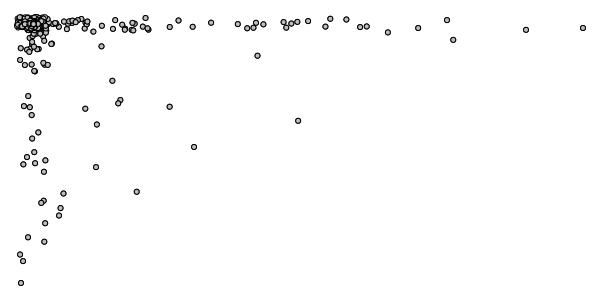

In [127]:
Image(filename=outfile) 

In [158]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 151828
Number of edges: 1492921
Density of the graph: 0.00012952868030383145


In [159]:
degrees = []
total = 0

for n in range(g.vcount()):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/g.vcount())
print("Maximum degree:", max(degrees))
print("Author with the maximum degree:", node_2_a[degrees.index(max(degrees))])

Average degree: 19.66595094448982
Maximum degree: 1072
Author with the maximum degree: Geschwind, Daniel H.


Degree having the maximum number of vertices: 6
Number of vertices having the most abundant degree: 10551


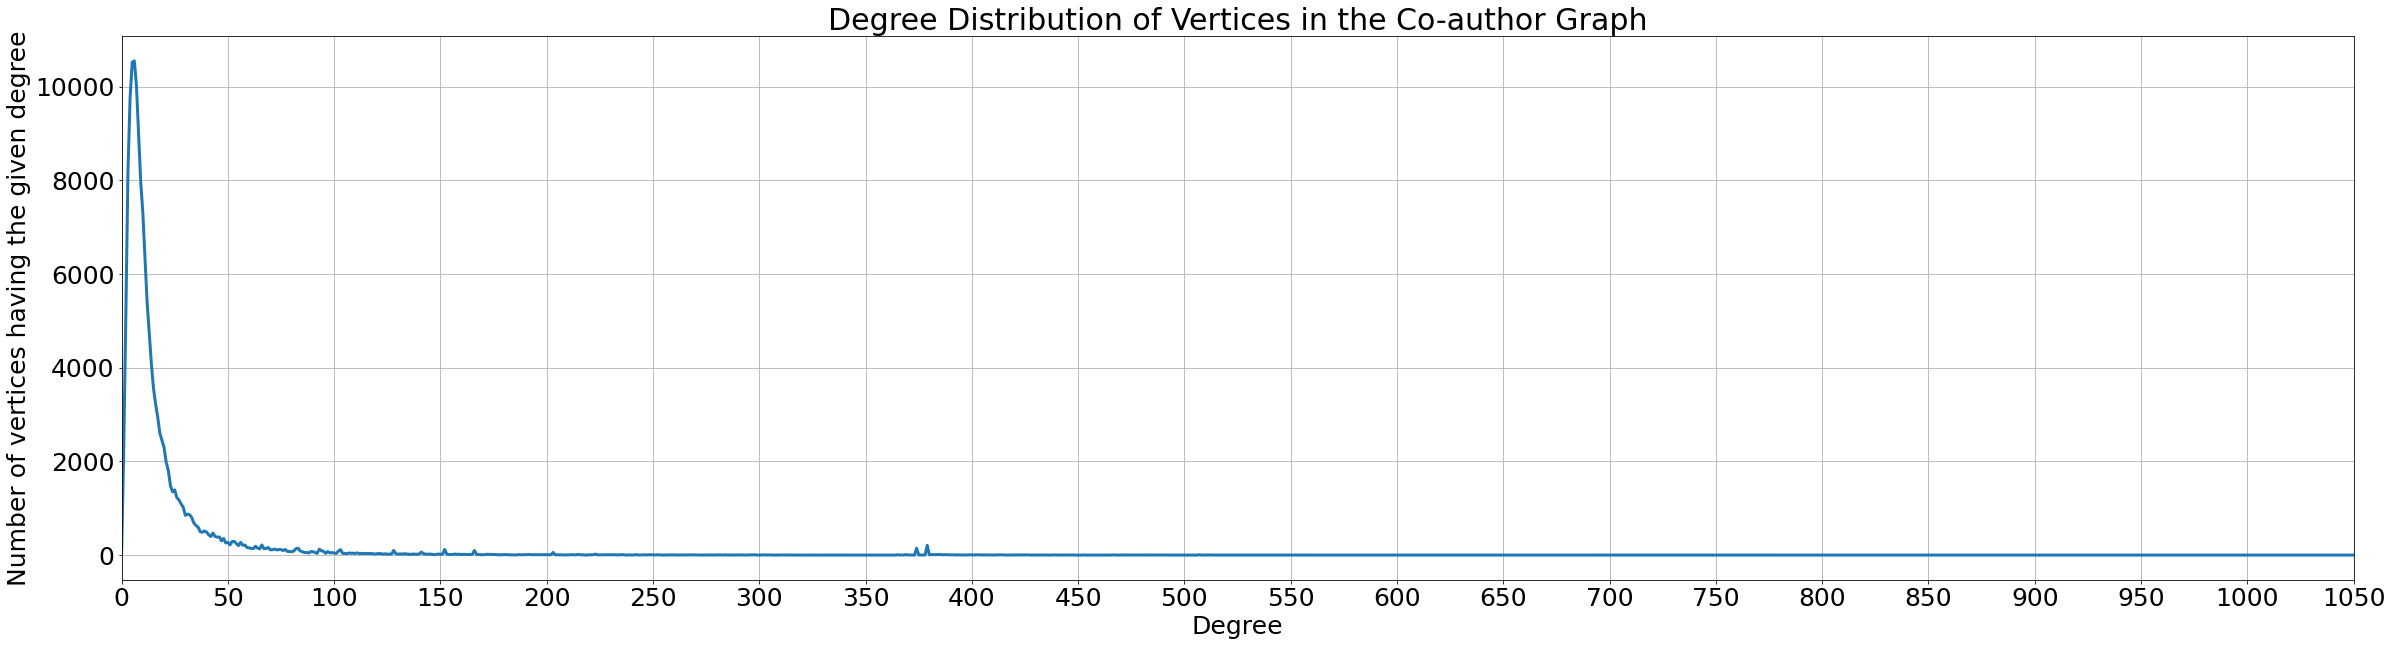

<Figure size 432x288 with 0 Axes>

In [160]:
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(1073)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in the Co-author Graph')

plt.xlim(0,100)
plt.xticks(np.arange(min(x), max(x)+1, 50.0))
plt.grid(True)
plt.show()
plt.draw()

In [161]:
g.summary()

'IGRAPH UN-- 151828 1492921 -- \n+ attr: name (v), year (e)'

## Get gender of names

In [254]:
node_2_fname = dict.fromkeys(node_2_a.keys())

for node in node_2_fname.keys():
    auth = node_2_a[node]
    auth = auth.replace('.', ' ')

    #splitting on space
    if (len(auth.split(', ')[-1].split()[0].strip(', ')) > 1):
        auth = auth.split(', ')[-1].split()[0].strip(', ')
    elif (np.size(auth.split(', ')[-1].split()) > 1):
        if (len(auth.split(', ')[-1].split()[1].strip(', ')) > 1):
            auth = auth.split(', ')[-1].split()[1].strip(', ')
        else:
            auth = ""
    else:
        auth = ""   

    node_2_fname[node] = auth
            
    
np.save(f"../data/{method}_node_2_fname.npy",node_2_fname,allow_pickle='TRUE')

In [ ]:
if buy_names:
    node_2_gender = dict.fromkeys(node_2_fname.keys())
    for node,idx in enumerate(node_2_gender.keys()):
        # check if this name has been found before
        auth = node_2_fname[node]
        hits = [val == auth for val in node_2_fname.values()]
        dup = (sum(hits) > 1) & any(np.where(hits)[0] < idx)

        # get estimated gender
        if (auth != "") & (not(dup)):
            url = "https://gender-api.com/get?key=" + genderAPI_key + "&name=%s" %(quote(auth))
            response = urlopen(url)
            decoded = response.read().decode('utf-8')
            gender = json.loads(decoded)
            gender.pop('country')
            gender.pop('duration')
            gender.pop('credits_used')
            node_2_gender[node] = gender
        elif (auth != "") & (dup):
            dup_key = [key  for (key, value) in node_2_fname.items() if value == auth]
            node_2_gender[node] = node_2_gender[dup_key[0]]
        elif auth == "":
            node_2_gender[node] = {"name":None,
                                  "name_sanitized":None,
                                  "gender":None,
                                  "accuracy":None,
                                  "samples":None}
    np.save(f"../data/{method}_node_2_gender.npy",node_2_fname,allow_pickle='TRUE')
else:
    node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
            
    
node_2_gender

In [255]:
node_2_fname

{0: 'Andre',
 1: 'Gian',
 2: 'Marisol',
 3: 'Edmar',
 4: 'Renata',
 5: 'Vinicius',
 6: 'Vitor',
 7: 'Umbertina',
 8: 'Andre',
 9: 'Benjamin',
 10: 'Rahul',
 11: 'Enrico',
 12: 'Richa',
 13: 'Samuel',
 14: 'Michael',
 15: 'Hanne',
 16: 'Roope',
 17: 'Emma',
 18: 'Melissa',
 19: 'Manoj',
 20: 'Kristy',
 21: 'Rosemary',
 22: 'Kate',
 23: 'Maria',
 24: 'Timothy',
 25: 'Rachel',
 26: 'Karen',
 27: 'Paula',
 28: 'Kathryn',
 29: 'Monique',
 30: 'Eppie',
 31: 'Michelle',
 32: 'Hugo',
 33: 'Isabella',
 34: 'Emanuela',
 35: 'Davide',
 36: 'SabrinaW',
 37: 'David',
 38: 'Gyula',
 39: 'Michael',
 40: 'Joshua',
 41: 'Oranee',
 42: 'Livia',
 43: 'Silvia',
 44: 'Mathieu',
 45: 'Guillaume',
 46: 'Charles',
 47: 'Sophie',
 48: 'Marie-Lorraine',
 49: 'Samia',
 50: 'Justine',
 51: 'Chantal',
 52: 'Bertrand',
 53: 'Alexis',
 54: 'Giovanni',
 55: 'Christel',
 56: 'Alexandra',
 57: 'Myriem',
 58: 'Mathieu',
 59: 'Dominique',
 60: 'Perrine',
 61: 'Pierre',
 62: 'Giulia',
 63: 'Paula',
 64: 'Rabab',
 65: 'Niz